# Tips for Timeseries Analysis

1. Use Time Series Cross-Validation
2. Account for Seasonality (SARIMA)
3. Incorporate Exogenous Variables (SARIMAX)
4. Feature Engineering
5. Model Selection and Comparison
6. Evaluation Metrics
7. Handling Non-Stationarity
8. Robustness to New Information
9. Data Quality
10. Automation and Scalability

### 1. Use Time Series Cross-Validation

**Rolling Forecast Origin** - Instead of a single train-test split, use time series cross-validation where you roll the training window forward over time. This better reflects the model's performance on unseen data and can provide a more robust estimate of forecast accuracy.

**Walk-Forward Validation** - At each step, train the model on past data and validate it on the next observation or a small validation set. This helps to mimic the actual forecasting process.

##### **1. Load and Preprocess the Data**

In [95]:
import pandas as pd
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [96]:
# Load the dataset
df = pd.read_csv('../EDA/ice_cream.csv', parse_dates=['DATE'])

In [97]:
# Print data
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [98]:
# Rename columns
df = df.rename(columns={'DATE': 'date','IPN31152N':'price'})

In [99]:
# Set the date as the index
df.set_index('date', inplace=True)

In [100]:
# Ensure data is sorted by date
df.sort_index(inplace=True)

##### **2. Define Time Series Cross-Validation**

In [101]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [102]:
# Define the number of splits for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

##### **3. Implement Cross-Validation and Model Evaluation**

In [103]:
import pmdarima as pm

# Lists to store evaluation metrics
mae_list = []
rmse_list = []

# Initialize variables for best model selection
best_avg_mae = float('inf')
best_avg_rmse = float('inf')
best_model_params = None

In [104]:
# Perform cross-validation and select the best model
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    
    # Fit the ARIMA model on the training data
    model = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
    
    # Predict the test data period
    forecast = model.predict(n_periods=len(test))
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    # Store metrics
    mae_list.append(mae)
    rmse_list.append(rmse)

    print(f"Fold MAE: {mae}, Fold RMSE: {rmse}")

    # Update best model if the current model has lower average MAE and RMSE
    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    
    if avg_mae < best_avg_mae and avg_rmse < best_avg_rmse:
        best_avg_mae = avg_mae
        best_avg_rmse = avg_rmse
        best_model_params = model.get_params()

Fold MAE: 12.47060475930851, Fold RMSE: 16.775372784766255
Fold MAE: 41.699414154647606, Fold RMSE: 47.83673845557131
Fold MAE: 26.59594286836952, Fold RMSE: 30.19492182443684
Fold MAE: 26.395462927144905, Fold RMSE: 32.35727730900496
Fold MAE: 14.13099518791011, Fold RMSE: 16.350834614571728


In [105]:
# Calculate average metrics across all folds
avg_mae = np.mean(mae_list)
avg_rmse = np.mean(rmse_list)

print(f"Average MAE: {avg_mae}")
print(f"Average RMSE: {avg_rmse}")

Average MAE: 24.258483979476132
Average RMSE: 28.70302899767022


##### **4. Train the Final Model and Make Predictions**

In [106]:
# Train the final model using the best model parameters
final_model = pm.ARIMA(**best_model_params)
final_model.fit(df)

ARIMA(order=(5, 0, 0), scoring_args={}, suppress_warnings=True)

In [107]:
# Predict future values (example: next 12 periods)
n_periods = 12
forecast = final_model.predict(n_periods=n_periods)

In [108]:
# Create a date range for the forecasted periods starting from the next period after the last date in 'df'
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

In [109]:
# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])

In [110]:
forecast_df

,forecast
2020-02-01,91.351666
2020-03-01,100.384158
2020-04-01,107.613661
2020-05-01,111.289687
2020-06-01,112.634757
2020-07-01,111.882124
2020-08-01,110.195273
2020-09-01,108.547783
2020-10-01,107.366795
2020-11-01,106.921716


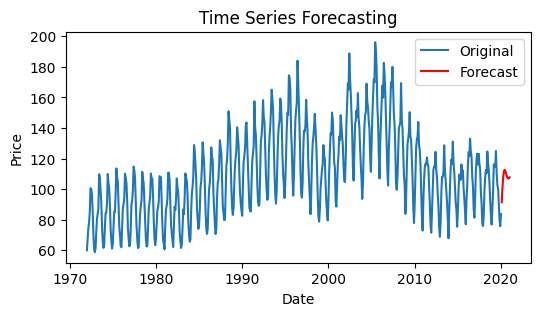

In [111]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(df.index, df['price'], label='Original')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series Forecasting')
plt.legend()
plt.show()

### 2. Account for Seasonality (SARIMA)

**SARIMA Models** - Use Seasonal ARIMA models if your data shows seasonal patterns. The seasonal components can significantly improve the model's accuracy by capturing repetitive patterns over specific periods (e.g., months, quarters).

**Seasonal Decomposition** - Decompose the time series into trend, seasonal, and residual components to better understand and model each aspect.

In [112]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [113]:
df.head()

,price
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


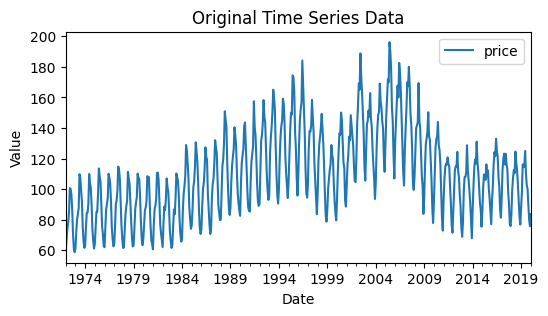

In [114]:
# Visualize the time series
df.plot(figsize=(6, 3))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Time Series Data')
plt.show()

In [115]:
# Fit the SARIMA model
# Example: SARIMA(1,1,1)(1,1,1)12 for monthly data with seasonal period of 12 months
sarima_model = SARIMAX(df['price'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_results = sarima_model.fit()

E:\PROJECTS - AI\ml-timeseries-study\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\PROJECTS - AI\ml-timeseries-study\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [116]:
# Forecast for future time periods
forecast_steps = 12  # Example: forecasting for 12 future periods (months)
forecast = sarima_results.forecast(steps=forecast_steps)

In [117]:
# Create index for the forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

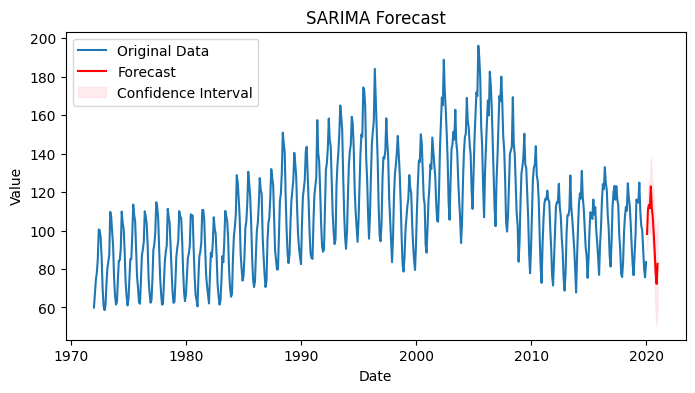

In [118]:
# Plot the original data and the forecast
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['price'], label='Original Data')
plt.plot(forecast_index, forecast, color='red', label='Forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

### 3. Incorporate Exogenous Variables (SARIMAX)

In [119]:
# Generate example data
np.random.seed(0)
dates = pd.date_range(start='2020-01-01', periods=36, freq='M')
sales = np.random.normal(100, 20, 36)  # Example monthly sales data
advertising = np.random.normal(50, 10, 36)  # Example monthly advertising expenditure

# Create a DataFrame with sales and advertising data
data = pd.DataFrame({'Date': dates, 'Sales': sales, 'Advertising': advertising})
data.set_index('Date', inplace=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_15904\1831889108.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=36, freq='M')


In [120]:
data.head()

,Sales,Advertising
Date,,
2020-01-31,135.281047,62.302907
2020-02-29,108.003144,62.023798
2020-03-31,119.574760,46.126732
2020-04-30,144.817864,46.976972
2020-05-31,137.351160,39.514470


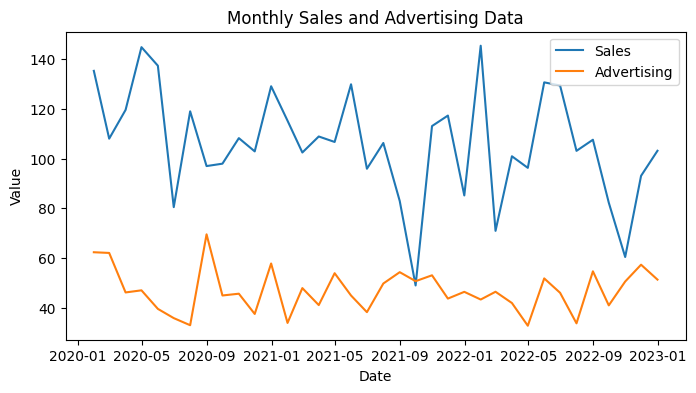

In [121]:
# Visualize the data
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['Sales'], label='Sales')
plt.plot(data.index, data['Advertising'], label='Advertising')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Monthly Sales and Advertising Data')
plt.legend()
plt.show()

In [122]:
# Fit the SARIMAX model with exogenous variable (advertising)
# Example SARIMAX(1,1,1)(1,1,1)12 model with an exogenous variable
sarimax_model = SARIMAX(data['Sales'], exog=data['Advertising'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_results = sarimax_model.fit()

E:\PROJECTS - AI\ml-timeseries-study\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
E:\PROJECTS - AI\ml-timeseries-study\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
E:\PROJECTS - AI\ml-timeseries-study\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
E:\PROJECTS - AI\ml-timeseries-study\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [123]:
# Forecast future sales with the exogenous variable
forecast_steps = 12  # Example: forecasting for 12 future periods (months)
exog_forecast = data['Advertising'].iloc[-forecast_steps:].values.reshape(-1, 1)  # Select only the exogenous data for the forecast period
forecast = sarimax_results.forecast(steps=forecast_steps, exog=exog_forecast)

C:\Users\Acer\AppData\Local\Temp\ipykernel_15904\808027678.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M'), forecast, color='red', label='Forecasted Sales')


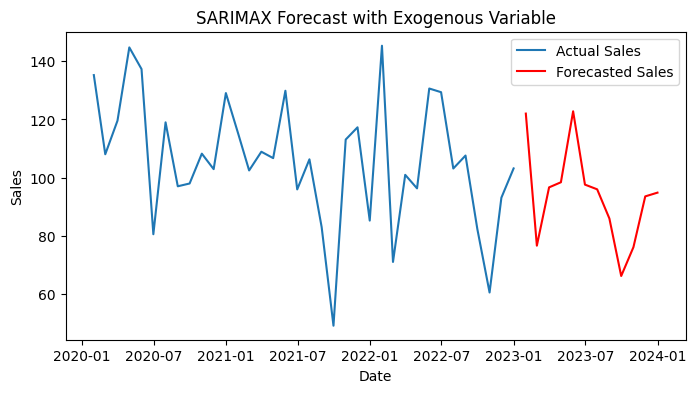

In [124]:
# Plot the actual sales data and the forecasted sales
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['Sales'], label='Actual Sales')
plt.plot(pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M'), forecast, color='red', label='Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMAX Forecast with Exogenous Variable')
plt.legend()
plt.show()

### 4. Feature Engineering

**Lag Features** - Create features based on lagged values of the time series. This helps the model understand temporal dependencies.

In [125]:
# Create lag features for the past k time periods
k = 3  # Number of lagged features
for i in range(1, k+1):
    df[f'price_lag_{i}'] = df['price'].shift(i)  # Shift the 'value' column by i time periods and create a new lag feature

In [126]:
df.head()

,price,price_lag_1,price_lag_2,price_lag_3
date,,,,
1972-01-01,59.9622,NaN,NaN,NaN
1972-02-01,67.0605,59.9622,NaN,NaN
1972-03-01,74.2350,67.0605,59.9622,NaN
1972-04-01,78.1120,74.2350,67.0605,59.9622
1972-05-01,84.7636,78.1120,74.2350,67.0605


**Rolling Statistics** - Calculate rolling means, medians, or other statistics to capture trends and seasonality.

In [127]:
# Calculate rolling mean and standard deviation for the past n time periods
n = 5  # Window size for rolling statistics
df['rolling_mean'] = df['price'].rolling(window=n).mean()  # Rolling mean
df['rolling_std'] = df['price'].rolling(window=n).std()    # Rolling standard deviation

In [128]:
df.head()

,price,price_lag_1,price_lag_2,price_lag_3,rolling_mean,rolling_std
date,,,,,,
1972-01-01,59.9622,NaN,NaN,NaN,NaN,NaN
1972-02-01,67.0605,59.9622,NaN,NaN,NaN,NaN
1972-03-01,74.2350,67.0605,59.9622,NaN,NaN,NaN
1972-04-01,78.1120,74.2350,67.0605,59.9622,NaN,NaN
1972-05-01,84.7636,78.1120,74.2350,67.0605,72.82666,9.632649


**Date-time Features** - Extract and use features like day of the week, month, year, or whether a day is a holiday.

In [129]:
# Extract date-time features such as day of the week, month, and year
df['day_of_week'] = df.index.dayofweek  # Day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
df['month'] = df.index.month            # Month (1=January, 2=February, ..., 12=December)
df['year'] = df.index.year              # Year

In [130]:
df.head()

,price,price_lag_1,price_lag_2,price_lag_3,rolling_mean,rolling_std,day_of_week,month,year
date,,,,,,,,,
1972-01-01,59.9622,NaN,NaN,NaN,NaN,NaN,5,1,1972
1972-02-01,67.0605,59.9622,NaN,NaN,NaN,NaN,1,2,1972
1972-03-01,74.2350,67.0605,59.9622,NaN,NaN,NaN,2,3,1972
1972-04-01,78.1120,74.2350,67.0605,59.9622,NaN,NaN,5,4,1972
1972-05-01,84.7636,78.1120,74.2350,67.0605,72.82666,9.632649,0,5,1972
